In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt

import glob
import xarray as xr
import datetime

In [2]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
save_path = "/glade/scratch/mhayman/holodec/holodec-ml-data/plane_unet/initial_test/"

In [4]:
# model file name to load
# set to empty string to start a new model
model_file = "test_model_20210622T130140"  # "test_model_yyyymmddTHHMMSS" # 20210622T130140

In [5]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [6]:
dtype = torch.complex64  # fft required data type

In [7]:
def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

# Pick the Dataset

In [8]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [9]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [10]:
f_sel = 35 #40
dataFile = file_list[f_sel]

In [11]:
h_ds = xr.open_dataset(dataFile)

# Build Output Map For Labels

In [12]:
n_bins = 100  # number of bins in histogram
n_holograms = 1000  # number of holograms to use in data set
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers
hologram_slice = slice(None,2*n_holograms)

In [13]:
histogram_lst = []
for holo_idx in h_ds['hologram_number'].values[hologram_slice]:
    hist_tpl = np.histogram(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],bins=z_bins)
    histogram_lst.append(hist_tpl[0])

Text(0.5, 0, 'z position [$\\mu m$]')

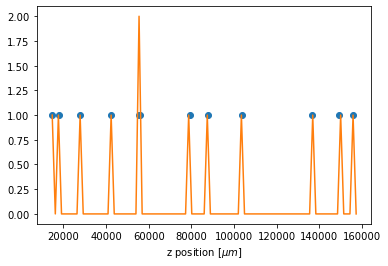

In [14]:
# confirm histogram and particle data are aligned
plt.figure()
plt.plot(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],np.ones(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)].shape),'o')
plt.plot(z_centers,histogram_lst[holo_idx])
plt.xlabel('z position [$\mu m$]')

In [15]:
histogram_arr = np.stack(histogram_lst,axis=0)
train_histogram_bin_arr = (histogram_arr[:n_holograms,:]>0).astype(float)
valid_histogram_bin_arr = (histogram_arr[n_holograms:,:]>0).astype(float)

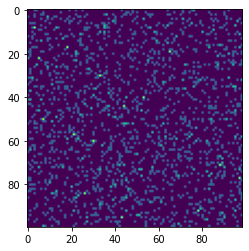

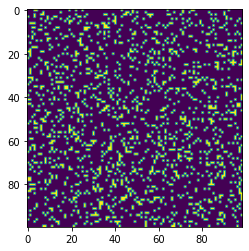

In [16]:
plt.figure()
plt.imshow(histogram_arr[0:100,:])
plt.figure()
plt.imshow(train_histogram_bin_arr[0:100,:])

# Build Reconstructed Plane Inputs

In [17]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 1
image_norm = 255.0

In [18]:
h_ds.attrs['zMin']

0.014

In [19]:
h_ds.attrs['zMax']

0.158

In [20]:
# Npadx = int(np.ceil(np.log2(Nx)))-Nx
# Npady = int(np.ceil(np.log2(Ny)))-Ny
# Nx = int(np.ceil(np.log2(Nx)))
# Ny = int(np.ceil(np.log2(Ny)))

In [21]:
# def pad_image(image_in):
#     if Npadx > 0 or Npady > 0:
#         image_out = np.zeros(Nx,Ny)
#         image_out[Npadx//2:-Npadx//2,Npady//2:-Npady//2] = image_in
#     else:
#         image_out = image_in
#     return image_out

In [22]:
x_arr = np.arange(-Nx//2,Nx//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [23]:
fx = torch.fft.fftfreq(Nx,dx,device=device)[None,:,None]
fy = torch.fft.fftfreq(Ny,dy,device=device)[None,None,:]
# z_rec = torch.tensor(z_centers*1e-6,device=device)[:,None,None]

Test Reconstruction Assumptions

(13, 600, 400)
(600,)
(400,)


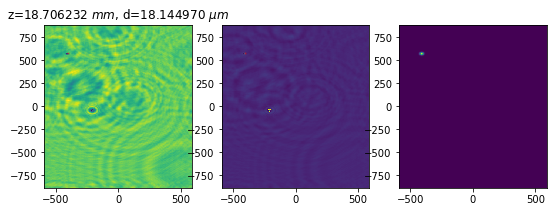

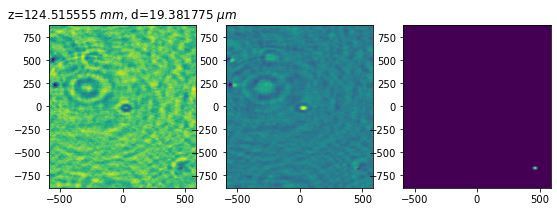

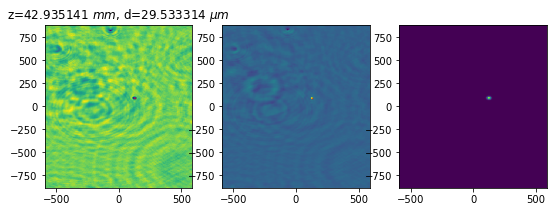

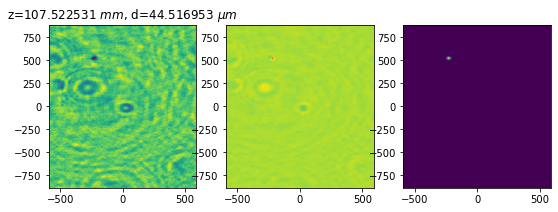

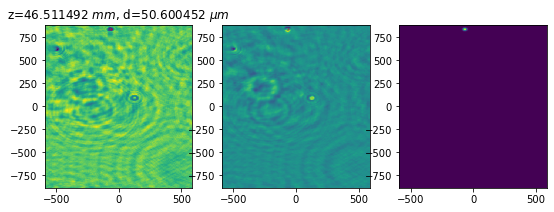

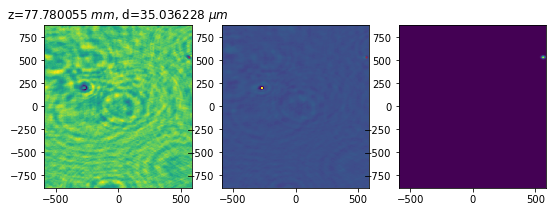

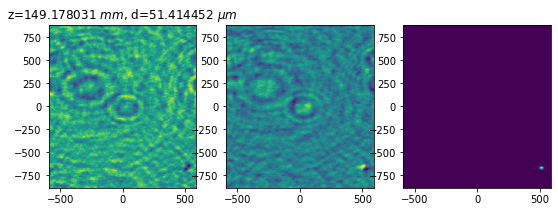

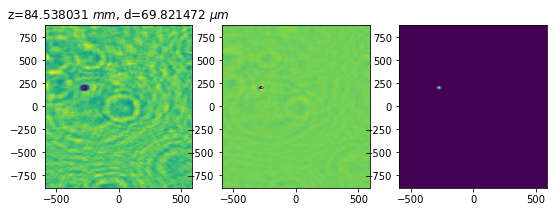

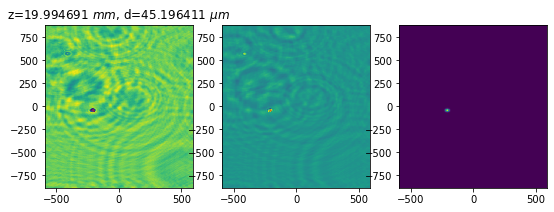

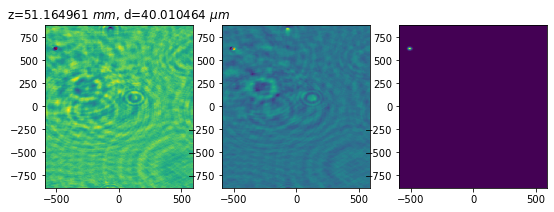

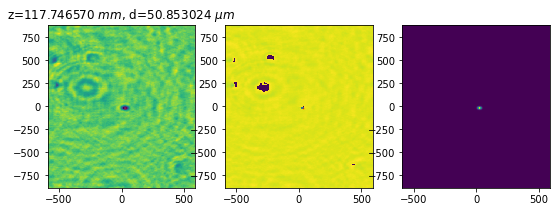

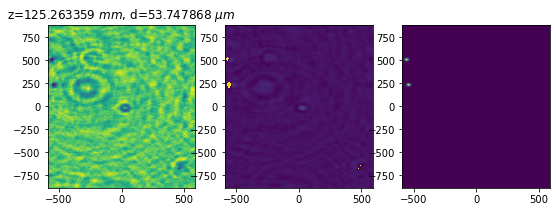

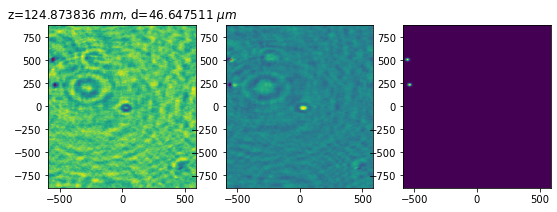

In [23]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]
z_plane = torch.tensor(zp*1e-6,device=device)[:,None,None]
E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
Eres = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

z_idx = np.digitize(zp,bins=z_bins)-1

z_maps = np.zeros((z_centers.size,)+h_ds['image'].shape[1:])

for p_idx,iz in enumerate(z_idx):
    z_maps[iz,:,:] += np.exp(-(y_arr[None,:]*1e6-yp[p_idx])**2/(2*(10)**2) - (x_arr[:,None]*1e6-xp[p_idx])**2/(2*(10)**2) )
    
    

print(Eres.shape)
print(x_arr.shape)
print(y_arr.shape)

for idx,z in enumerate(zp):
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,np.abs(Eres[idx,:,:]))
    ax[0].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,np.angle(Eres[idx,:,:]))
    ax[1].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)
    iz = np.argmin(np.abs(z_centers-z))
    ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,z_maps[iz,:,:])
#     ax[2].scatter(yp[idx],xp[idx],c='r',s=2,alpha=0.3)

In [24]:
print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

memory available 0.002097152 GB
memory used 4.608000000000001e-06 GB


In [25]:
marker_size = 10  # gaussian marker size in micro meters
gaus_mult = 1   # multiplier to apply to gaussian (to increase effect in loss function)
n_planes=5  # number of planes included as an input channel

Eset = []
# Eset1 = []
# Eset2 = []
histset = []
z_map_lst = []
start_time = datetime.datetime.now()
for holo_idx in tqdm.tqdm(range(2*n_holograms),leave=True):
    part_idx = np.where(histogram_arr[holo_idx,:] > 0)[0]
    part_idx = part_idx[(part_idx > (n_planes//2)) & (part_idx < z_centers.size-(n_planes//2))]
    empt_idx = np.where(histogram_arr[holo_idx,:] == 0)[0]
    empt_idx = empt_idx[(empt_idx > (n_planes//2)) & (empt_idx < z_centers.size-(n_planes//2))]
    if len(empt_idx) > 0 and len(part_idx) > 0:
        set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
        set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
        plane_set = []
        for plane_idx in np.concatenate([set_part,set_empt]):
            plane_set.append(np.arange(-(n_planes//2),n_planes//2+1)+plane_idx)

        z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate(plane_set)],device=device)[:,None,None]


    #     set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
    #     set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
    #     z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate([set_part,set_empt])],device=device)[:,None,None]

        # build UNET output mask
        p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
        xp = h_ds['x'].values[p_idx]
        yp = h_ds['y'].values[p_idx]
        zp = h_ds['z'].values[p_idx]
        dp = h_ds['d'].values[p_idx]

        z_maps = np.zeros((set_part.size+set_empt.size,)+h_ds['image'].shape[1:])

        z_idx = np.digitize(zp,bins=z_bins)-1
        for ip,iz in enumerate(z_idx):
            if iz in set_part:
                map_idx = np.where(iz == set_part)[0]
                z_maps[map_idx,:,:] += gaus_mult*np.exp(-(y_arr[None,:]*1e6-yp[ip])**2/(2*marker_size**2) - (x_arr[:,None]*1e6-xp[ip])**2/(2*marker_size**2) )

        z_map_lst.append(torch.tensor(z_maps))



        # reconstruct the image
        image_in = h_ds['image'].isel(hologram_number=holo_idx).values
        image_in = image_in/image_in.max()
        E_input = torch.tensor(image_in,device=device,dtype=dtype)[None,:,:] 
        Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu().reshape((n_planes,2*num_per_holo,Nx,Ny)).permute(1,0,2,3) # .reshape((2*num_per_holo,n_planes,Nx,Ny))
#         Eset.append(torch.cat([Eres.real,Eres.imag],dim=1))
        Eset.append(torch.cat([Eres.abs(),Eres.angle()],dim=1))
#         Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu()
    #     Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))

    #     Eset1.append(Eres[:,None,:,:].abs())
    #     Eset2.append(Eres[:,None,:,:].angle())
        histset.append(histogram_arr[holo_idx,np.concatenate([set_part,set_empt])])

#     # Include All Reconstructions
#     E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
#     Eres = torch_holo_set(E_input,fx,fy,z_rec,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
#     # Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))


end_time = datetime.datetime.now()

print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

100%|██████████| 2000/2000 [03:41<00:00,  9.02it/s]

memory available 0.142606336 GB
memory used 0.0019251200000000002 GB


In [26]:
torch.cuda.get_device_properties(0).total_memory*1e-9

34.089730048

In [27]:
exec_time = end_time-start_time
print(f'executed {2*num_per_holo*len(Eset)} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/(2*num_per_holo*len(Eset))} seconds per plane')

# exec_time = end_time-start_time
# print(f'executed {z_centers.size*len(Eset)} planes in {exec_time.total_seconds()} seconds')
# print(f' for {exec_time.total_seconds()/(z_centers.size*len(Eset))} seconds per plane')

executed 4000 planes in 221.630266 seconds
 for 0.0554075665 seconds per plane


In [28]:
idx_arr = np.arange(len(Eset)).astype(int)
train_idx = np.random.choice(idx_arr, idx_arr[-1]//2 ,replace=False)
valid_idx = np.delete(idx_arr,train_idx)

print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

memory available 0.142606336 GB
memory used 0.0019251200000000002 GB


In [29]:
tmp = torch.cat(Eset,dim=0)
print("cat complete")
train_inputs = tmp[train_idx,...]
print("training complete")
valid_inputs = tmp[valid_idx,...]
print("validation complete")

# train_inputs = torch.cat(Eset,dim=0)[train_idx,...]
# valid_inputs = torch.cat(Eset,dim=0)[valid_idx,...]

# train_inputs1 = torch.cat(Eset1,dim=0)[train_idx,...]
# valid_inputs1 = torch.cat(Eset1,dim=0)[valid_idx,...]
# train_inputs2 = torch.cat(Eset2,dim=0)[train_idx,...]/np.pi
# valid_inputs2 = torch.cat(Eset2,dim=0)[valid_idx,...]/np.pi

print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

cat complete
training complete
validation complete
memory available 0.142606336 GB
memory used 0.0019251200000000002 GB


In [30]:
z_map_tns = torch.cat(z_map_lst,dim=0)[:,None,:,:]

In [31]:
train_labels = z_map_tns[train_idx,...]
valid_labels = z_map_tns[valid_idx,...]

print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

memory available 0.142606336 GB
memory used 0.0019251200000000002 GB


In [32]:
hist_labels = np.concatenate(histset)

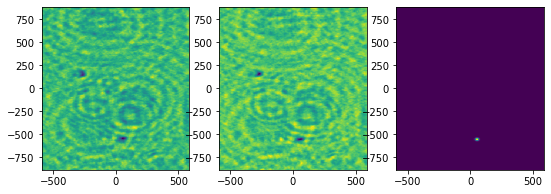

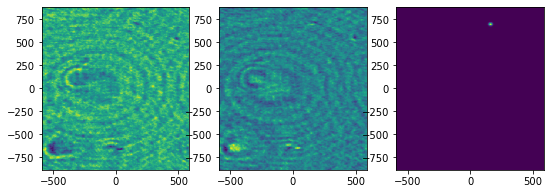

In [32]:
idx = np.where(hist_labels[train_idx]>0)[0][3]
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,train_inputs[idx,0,:,:])
ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,train_inputs[idx,1,:,:])
ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,train_labels[idx,0,:,:])


idx = np.where(hist_labels[valid_idx]>0)[0][4]
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,n_planes//2,:,:])
ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,n_planes+n_planes//2,:,:])
ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_labels[idx,0,:,:])

In [33]:
train_inputs.max()

tensor(3.1416, dtype=torch.float64)

In [34]:
train_inputs.shape

torch.Size([999, 10, 600, 400])

In [ ]:
# conv_size = 7
# pool_stride = 4
# print(train_inputs.float()[5:6,...].shape)
# x1 = nn.Conv2d(2, 4, conv_size,padding=(conv_size-1)//2)(train_inputs.float()[5:6,...]) # ,padding=(conv_size-1)//2
# print(x1.shape)
# print()
# x2 = nn.MaxPool2d(pool_stride, pool_stride)(x1)
# print(x2.shape)
# x3 = nn.ConvTranspose2d(4, 2, conv_size-pool_stride//2, stride=pool_stride, padding=(conv_size-1-pool_stride//2)//2)(x2) # 
# print(x3.shape)

In [ ]:
idx = np.where(hist_labels[valid_idx]>0)[0][1]
fig,ax = plt.subplots(2,n_planes+1,figsize=(3*(n_planes+1),6))
for pln_idx in range(n_planes):
    ax[0,pln_idx].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,pln_idx,...])
    ax[1,pln_idx].pcolormesh(y_arr*1e6,x_arr*1e6,valid_inputs[idx,n_planes+pln_idx,...])
ax[0,n_planes].pcolormesh(y_arr*1e6,x_arr*1e6,valid_labels[idx,0,...])

# Build Model

In [33]:
epochs = 20
optimizer_type = "adam"
learning_rate = 1e-5
batch_size = 8
dtype = torch.float

In [34]:
# train_labels = torch.tensor(train_histogram_bin_arr.reshape(-1,1),dtype=dtype)
# valid_labels = torch.tensor(valid_histogram_bin_arr.reshape(-1,1),dtype=dtype)

# ### TODO ###
# train_labels = torch.tensor(hist_labels[train_idx],dtype=dtype)[:,None]
# valid_labels = torch.tensor(hist_labels[valid_idx],dtype=dtype)[:,None]

In [35]:
train_labels.shape

torch.Size([999, 1, 600, 400])

In [36]:
mix = 1e-1
def element_weighted_MSELoss(y_hat, y):
    weights = (1-mix)*y + mix
    criterion = torch.nn.MSELoss(reduction='none')
    loss = criterion(y_hat, y)
    loss = loss * weights
    return loss.sum() / weights.sum()

In [37]:
# loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()
# loss_fn = nn.MSELoss()
loss_fn = element_weighted_MSELoss

In [38]:
input_shape = train_inputs.shape[1:]
output_shape = train_labels.shape[1:]
print(input_shape)
print(output_shape)

torch.Size([10, 600, 400])
torch.Size([1, 600, 400])


In [39]:
PoolStride = 2  # don't change this.  I haven't figured out how to match of dims with other strides
ConvSize = 5

In [40]:
class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=ConvSize, padding=(ConvSize-1)//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=ConvSize, padding=(ConvSize-1)//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# class DownSamp(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DownSamp, self).__init__()
#         self.doub_conv = DoubleConv(in_channels,out_channels)
#         self.pool = nn.MaxPool2d(PoolStride, PoolStride)

#     def forward(self, x):
#         return self.pool(self.doub_conv(x))
    
# class UpSamp(nn.Module):
#     def __init__(self, in_channels, mid_channels, out_channels):
#         super(UpSamp, self).__init__()
#         self.conv_transp = nn.ConvTranspose2d(in_channels, 
#                                             in_channels, 
#                                             ConvSize-PoolStride//2 , 
#                                             stride=PoolStride, 
#                                             padding=(ConvSize-1-PoolStride//2)//2)
#         self.doub_conv = DoubleConv(mid_channels,out_channels)

#     def forward(self, x, xf):
#         return self.doub_conv(torch.cat([self.conv_transp(x),xf],dim=1))

In [41]:
# ResNet 50 notebook : /glade/work/schreck/repos/goes16ci/gunther_notebook/latest.ipynb
ChanCount = 4


class XY_Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1d = DoubleConv(2*n_planes, ChanCount*2*n_planes)
        self.conv2d = DoubleConv(ChanCount*2*n_planes, 2*ChanCount*2*n_planes)
        self.conv3d = DoubleConv(2*ChanCount*2*n_planes, 4*ChanCount*2*n_planes)
        self.conv4d = DoubleConv(4*ChanCount*2*n_planes, 8*ChanCount*2*n_planes)
#         self.conv5d = DoubleConv(32, 64)
        
#         self.convT4u = nn.ConvTranspose2d(64, 64, ConvSize-PoolStride//2, 
#                                             stride=PoolStride, 
#                                             padding=(ConvSize-1-PoolStride//2)//2)
        
#         self.conv4u = DoubleConv(32+64, 32)
        
        self.convT3u = nn.ConvTranspose2d(8*ChanCount*2*n_planes, 8*ChanCount*2*n_planes, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        
        self.conv3u = DoubleConv((4+8)*ChanCount*2*n_planes, 4*ChanCount*2*n_planes)
        
        self.convT2u = nn.ConvTranspose2d(4*ChanCount*2*n_planes, 4*ChanCount*2*n_planes, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        
        self.conv2u = DoubleConv((2+4)*ChanCount*2*n_planes, 2*ChanCount*2*n_planes)
        
        self.convT1u = nn.ConvTranspose2d(2*ChanCount*2*n_planes, 2*ChanCount*2*n_planes, ConvSize-PoolStride//2, 
                                            stride=PoolStride, 
                                            padding=(ConvSize-1-PoolStride//2)//2)
        self.conv1u = DoubleConv((1+2)*ChanCount*2*n_planes, ChanCount*2*n_planes)
    
        
        self.pool = nn.MaxPool2d(PoolStride, PoolStride)
        
        self.conv_out = nn.Conv2d(ChanCount*2*n_planes, 1, 1)
        

    def forward(self, x):
        x1 = self.conv1d(x)
        x2 = self.conv2d(self.pool(x1))
        x3 = self.conv3d(self.pool(x2))
        x4 = self.conv4d(self.pool(x3))
#         x5 = self.conv5d(self.pool(x4))

#         x4 = torch.cat([self.convT4u(x5),x4],dim=1)
#         x4 = self.conv4u(x4)
        x3 = torch.cat([self.convT3u(x4),x3],dim=1)
        x3 = self.conv3u(x3)
        x2 = torch.cat([self.convT2u(x3),x2],dim=1)
        x2 = self.conv2u(x2)
        x1 = torch.cat([self.convT1u(x2),x1],dim=1)
        x1 = self.conv1u(x1)
        
        return F.sigmoid(self.conv_out(x1))

    


In [42]:
if len(model_file) == 0:
    unet_model = XY_Unet()
    unet_model.to(device)
else:
    unet_model = torch.load(save_path+model_file) # "test_model_20210622T130140"
    unet_model.to(device)

In [43]:
# unet_model = torch.load(save_path+"test_model_20210622T130140")
# unet_model.to(device)

In [44]:
print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

memory available 0.14470348800000002 GB
memory used 0.04537344 GB


In [45]:
# learning_rate = 1e-6

In [46]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(unet_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(unet_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )

In [47]:
# scheduler = ReduceLROnPlateau(optimizer, patience=4, verbose=True)

In [48]:
train_ds = TensorDataset(train_inputs.float(), train_labels.float())
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(valid_inputs.float(), valid_labels.float())
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# train_ds = TensorDataset(train_inputs.float().to(device), train_labels.float().to(device))
# train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

# valid_ds = TensorDataset(valid_inputs.float().to(device), valid_labels.float().to(device))
# valid_dl = DataLoader(valid_ds, batch_size=batch_size)

print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

memory available 0.14470348800000002 GB
memory used 0.04537344 GB


In [49]:
train_loss_hist = []
valid_loss_hist = []

In [58]:
epochs=20

In [59]:
train_time = datetime.datetime.now()
batches_per_epoch = len(train_dl)+1


for epoch in range(epochs):
    train_loss = 0
    unet_model.train()
    for batch_idx,(xb,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch):
        pred = unet_model(xb.to(device))
        loss = loss_fn(pred*gaus_mult, yb.to(device))
        train_loss += loss.sum().to('cpu').item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    unet_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(unet_model(xb.to(device))*gaus_mult, yb.to(device)).to('cpu') for xb, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss_hist[-1], valid_loss_hist[-1])

  0%|          | 0/126 [00:00<?, ?it/s]

0 0.0002815781598328613 0.0003979275269167764


  0%|          | 0/126 [00:00<?, ?it/s]

1 0.00026851618703221903 0.00037258006041012115


  0%|          | 0/126 [00:00<?, ?it/s]

2 0.0002632692660554312 0.0003796428855922487


  0%|          | 0/126 [00:00<?, ?it/s]

3 0.00026001929386984556 0.0003723238727876118


  0%|          | 0/126 [00:00<?, ?it/s]

4 0.0002611860705073923 0.00036789234431963116


  0%|          | 0/126 [00:00<?, ?it/s]

5 0.00025192398362560196 0.0003549905700816049


  0%|          | 0/126 [00:00<?, ?it/s]

6 0.00024785966327181086 0.0003643493862852218


  0%|          | 0/126 [00:00<?, ?it/s]

7 0.0002433973618899472 0.000381920634517594


  0%|          | 0/126 [00:00<?, ?it/s]

8 0.0002377918308484368 0.0004507866170671251


  0%|          | 0/126 [00:00<?, ?it/s]

9 0.00024124520045006647 0.0003575715458109265


  0%|          | 0/126 [00:00<?, ?it/s]

10 0.00022918866656254977 0.0003629814951665818


  0%|          | 0/126 [00:00<?, ?it/s]

11 0.00022632758022518828 0.0003659802060278635


  0%|          | 0/126 [00:00<?, ?it/s]

12 0.00022454860009020195 0.0003769737446591968


  0%|          | 0/126 [00:00<?, ?it/s]

13 0.00021585421764757485 0.00035356378389729396


  0%|          | 0/126 [00:00<?, ?it/s]

14 0.00022049150906968863 0.0003563626595432796


  0%|          | 0/126 [00:00<?, ?it/s]

15 0.0002122916132211685 0.00037517472510299987


  0%|          | 0/126 [00:00<?, ?it/s]

16 0.00019961076381150633 0.0003439814502757693


  0%|          | 0/126 [00:00<?, ?it/s]

17 0.00020791050005936995 0.0003501263166230822


  0%|          | 0/126 [00:00<?, ?it/s]

18 0.0002033000380906742 0.0003458509251238808


 99%|█████████▉| 125/126 [01:37<00:00,  1.28it/s]


19 0.00019513339991681278 0.0003586770700556891


In [ ]:
torch.cuda.empty_cache()

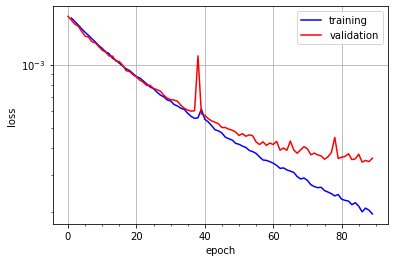

In [60]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()
plt.savefig(save_path+"figures/test_model_training_data" +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

In [63]:
valid_sets = []
with torch.no_grad():
    for xv, yv in valid_dl:
        valid_sets.append([unet_model(xv.to(device)).detach().cpu().numpy(), yv.detach().numpy(), xv.detach().numpy()])

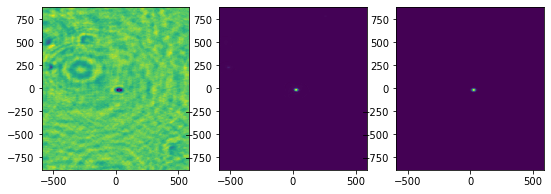

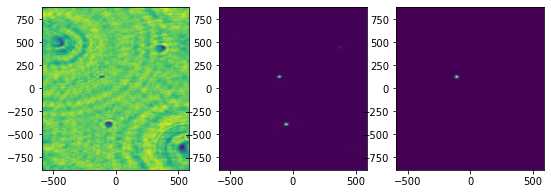

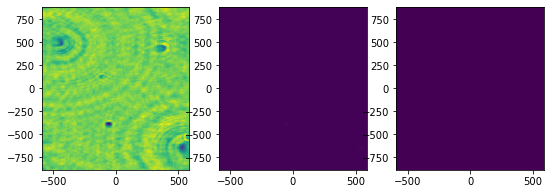

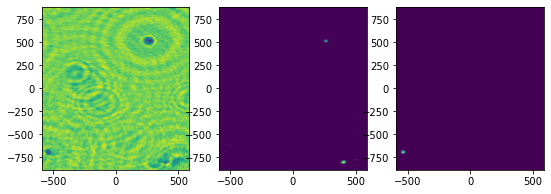

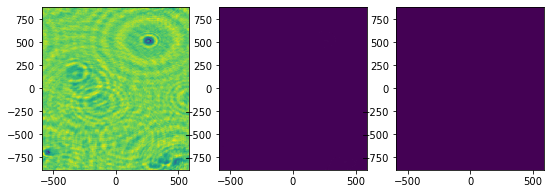

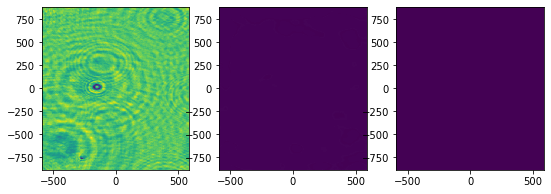

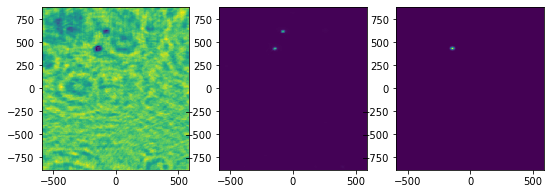

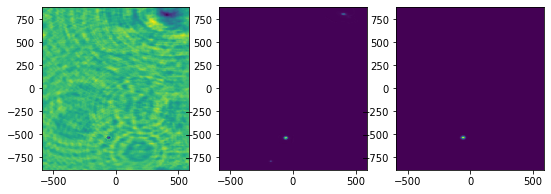

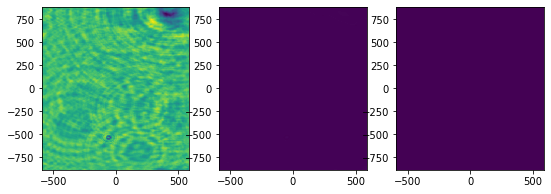

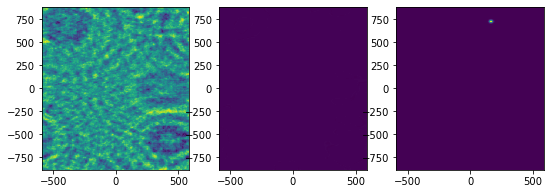

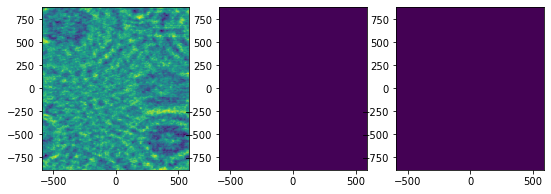

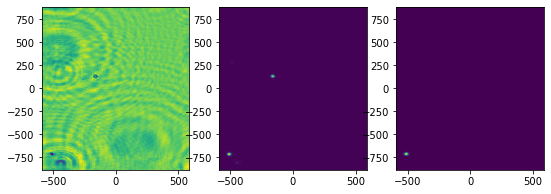

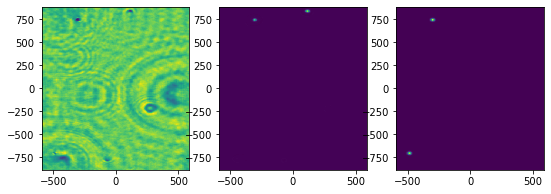

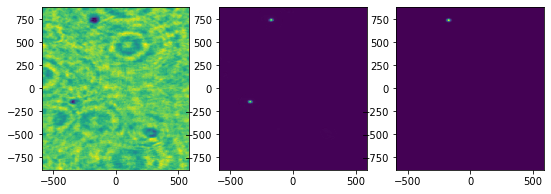

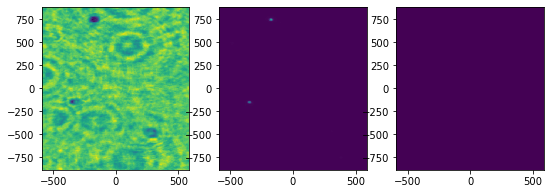

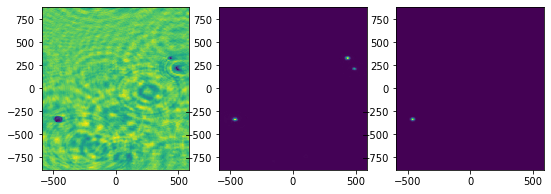

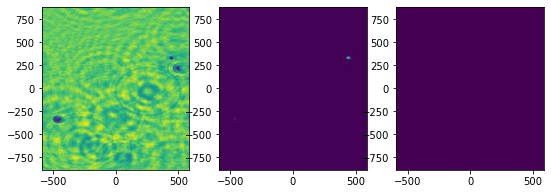

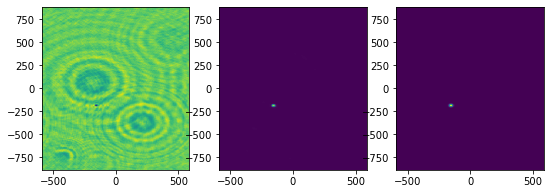

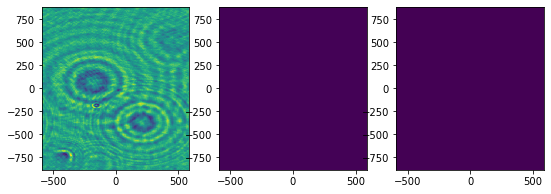

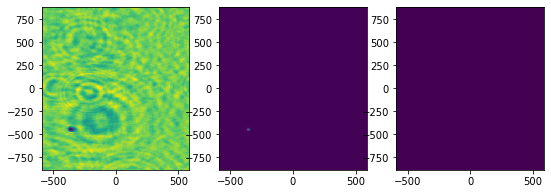

In [64]:
for vld_idx in range(20):
    lst_idx = vld_idx//batch_size
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[lst_idx][2][np.mod(vld_idx,batch_size),n_planes//2-1,...])
    ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[lst_idx][0][np.mod(vld_idx,batch_size),0,...],vmin=0,vmax=1)
    ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[lst_idx][1][np.mod(vld_idx,batch_size),0,...],vmin=0,vmax=1)
    plt.savefig(save_path+"figures/validation_result_%d"%vld_idx +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

# vld_idx = 0
# fig,ax = plt.subplots(1,3,figsize=(9,3))
# ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][2][vld_idx,0,...])
# ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][0][vld_idx,0,...],vmin=0,vmax=1)
# ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][1][vld_idx,0,...],vmin=0,vmax=1)
# plt.savefig(save_path+"figures/validation_result_%d"%vld_idx +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

# vld_idx = 1
# fig,ax = plt.subplots(1,3,figsize=(9,3))
# ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][2][vld_idx,0,...])
# ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][0][vld_idx,0,...],vmin=0,vmax=1)
# ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][1][vld_idx,0,...],vmin=0,vmax=1)
# plt.savefig(save_path+"figures/validation_result_%d"%vld_idx +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

# vld_idx = 2
# fig,ax = plt.subplots(1,3,figsize=(9,3))
# ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][2][vld_idx,0,...])
# ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][0][vld_idx,0,...],vmin=0,vmax=1)
# ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][1][vld_idx,0,...],vmin=0,vmax=1)
# plt.savefig(save_path+"figures/validation_result_%d"%vld_idx +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

# vld_idx = 3
# fig,ax = plt.subplots(1,3,figsize=(9,3))
# ax[0].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][2][vld_idx,0,...])
# ax[1].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][0][vld_idx,0,...],vmin=0,vmax=1)
# ax[2].pcolormesh(y_arr*1e6,x_arr*1e6,valid_sets[0][1][vld_idx,0,...],vmin=0,vmax=1)
# plt.savefig(save_path+"figures/validation_result_%d"%vld_idx +train_time.strftime("_%Y%m%dT%H%M%S")+".png",dpi=300)

In [61]:
print(train_time.strftime("%Y%m%dT%H%M%S"))

20210623T115129


In [62]:
torch.save(unet_model, save_path+"test_model" +train_time.strftime("_%Y%m%dT%H%M%S")+"")

In [ ]:
print(f"memory available {torch.cuda.memory_reserved(0)*1e-9} GB")
print(f"memory used {torch.cuda.memory_allocated(0)*1e-9} GB")

In [100]:
np.sum(valid_sets[0][0][2,0,...])

111800.12

In [101]:
ypred = unet_model(xb)
print(yb.shape)

torch.Size([39, 1, 600, 400])


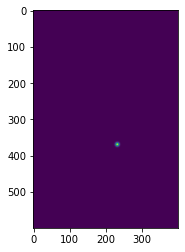

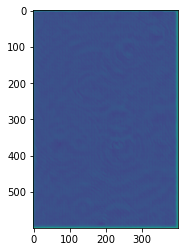

In [102]:
plt.figure()
plt.imshow(yb[0,0,...].cpu().detach().numpy())

plt.figure()
plt.imshow(ypred[0,0,...].cpu().detach().numpy())

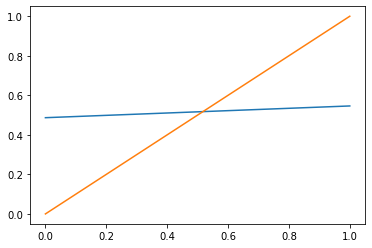

In [39]:
plt.figure()
plt.plot(valid_sets[1][0])
plt.plot(valid_sets[1][1])

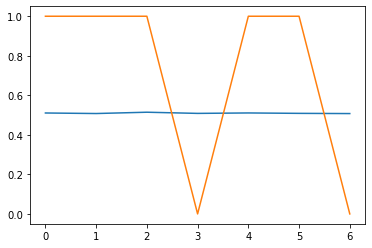

In [40]:
plt.figure()
plt.plot(pred.detach().cpu().numpy())
plt.plot(yb.detach().cpu().numpy())

In [108]:
h_ds

<xarray.Dataset>
Dimensions:         (hologram_number: 50000, particle: 500000, patch_number: 800000, patch_xsize: 128, patch_ysize: 128, xsize: 512, ysize: 512)
Dimensions without coordinates: hologram_number, particle, patch_number, patch_xsize, patch_ysize, xsize, ysize
Data variables: (12/16)
    hid             (particle) float32 1.0 1.0 1.0 1.0 ... 5e+04 5e+04 5e+04
    d               (particle) float32 36.48 45.38 25.82 ... 32.3 9.01 40.48
    x               (particle) float32 253.9 22.78 732.8 ... -616.6 -431.8
    y               (particle) float32 708.5 -600.7 552.2 ... 106.1 -190.7 662.5
    z               (particle) float32 5.645e+04 1.438e+05 ... 1.419e+05
    n0              (particle) float32 ...
    ...              ...
    x_pixels        (particle) float32 ...
    y_pixels        (particle) float32 ...
    pid             (particle) float32 ...
    x_patch_pixels  (particle) float32 ...
    y_patch_pixels  (particle) float32 ...
    patch           (patch_number, patch_xsize, patch_ysize) uint8 ...
Attributes: (12/33)
    DateCreated:           10-Feb-2021
    Nx:                    512.0
    Ny:                    512.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    monodisperse:          0.0
    should_cache:          1
    Nx_patch:              128.0
    Ny_patch:              128.0
    nPatches:              800000.0
    PatchesPerHologram:    16.0